# Geometry of the Scattering Transform

In this notebook, we investigate the spectral distribution of the scattering transform
of small images, with special focus on correlation between features and eigenvalue distribution

In [1]:
import os
import sys
from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import torch
import kymatio as km
from  matplotlib import pyplot as plt

sys.path.append("..")

from lib.data.data_loading import ClassificationDataset
from lib.dimensionality_reduction.dimensionality_reduction import compute_eigendecomposition 
from lib.data.data_processing import convert_images_to_scat, convert_loader_to_scat, get_classwise_data
from lib.projections.principal_angles import compute_principal_angles, \
    compute_angle_statistics, display_principal_angle_statistics, subspace_affinity
from lib.utils.visualizations import display_subset_data, display_cluster_features
from CONFIG import CONFIG

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
ROOT_PATH = os.path.dirname(os.getcwd())
DATA_PATH = os.path.join(CONFIG["paths"]["data_path"], "data")
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Global Variables

In [4]:
dataset_name = "mnist"  # dataset to investigate
subset_size = 0.1       # percentage of the data to use 
batch_size = 128        # number of images per batch
n_angles = 10           # number of principal angles to compute
J = 3                   # spatial field of the kernel is 2**J 
L = 8                   # number of angles in the kernel
shape = (32,32)         # shape of the input images
max_order = 2           # depth of the network

In [5]:
# defining the scattering network
scattering_layer = km.Scattering2D(J=J, shape=shape, max_order=max_order, L=L)
if DEVICE.type == 'cuda':
    scattering_layer = scattering_layer.cuda()

# Eigenvalue Distribution

In this section, we investigate the effect that the scattering transform has on the eigenvalue distribution of the MNIST dataset.
In particular, we compute the compute the eigenvalue distribution for a subset of the data in both domains. Furthermore, we also
compute the eigenvalue distribution for especific classes, namely, the classes containing digits 0 and 2 respectively.

In [6]:
dataset = ClassificationDataset(data_path=DATA_PATH, dataset_name=dataset_name, valid_size=subset_size) 
valid_loader = dataset.get_data_loader(split="valid", batch_size=batch_size)

In [7]:
imgs, scat_feats, labels = convert_loader_to_scat(valid_loader, scattering=scattering_layer,
                                                  device=DEVICE, equalize=True, verbose=1)

100%|██████████| 47/47 [00:20<00:00,  2.30it/s]


In [8]:
# flattening scattering transformed data into vectors
n_imgs = len(imgs)
scat_data = scat_feats.reshape(n_imgs, -1)

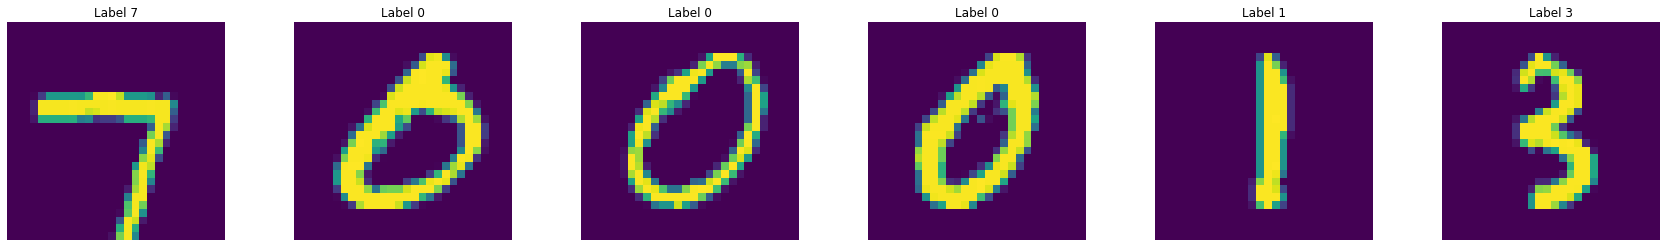

In [9]:
display_subset_data(imgs, labels, shuffle=True)

In [10]:
img_data_0, ids_0 = get_classwise_data(data=imgs, labels=labels, label=0, get_ids=True)
img_data_2, ids_2 = get_classwise_data(data=imgs, labels=labels, label=2, get_ids=True)
scat_data_0 = scat_data[ids_0, :]
scat_data_2 = scat_data[ids_2, :]

In [11]:
img_eigenvalues_all, _ = compute_eigendecomposition(imgs)
scat_eigenvalues_all,_ = compute_eigendecomposition(scat_data)

In [12]:
img_evals_0, img_evect_0 = compute_eigendecomposition(img_data_0)
img_evals_2, img_evect_2 = compute_eigendecomposition(img_data_2)

In [13]:
scat_evals_0, scat_evect_0 = compute_eigendecomposition(scat_data_0)
scat_evals_2, scat_evect_2 = compute_eigendecomposition(scat_data_2)

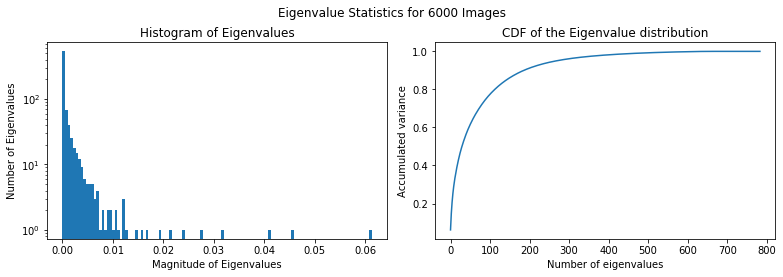

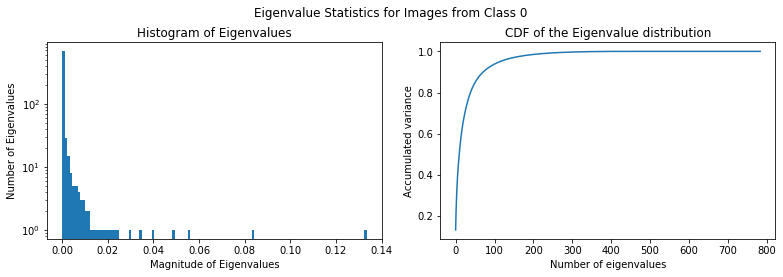

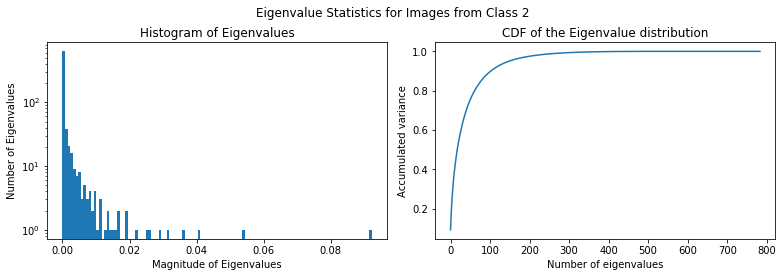

In [14]:
display_cluster_features(img_eigenvalues_all, suptitle=f"Eigenvalue Statistics for {n_imgs} Images")
display_cluster_features(img_evals_0, suptitle="Eigenvalue Statistics for Images from Class 0 ")
display_cluster_features(img_evals_2, suptitle="Eigenvalue Statistics for Images from Class 2")

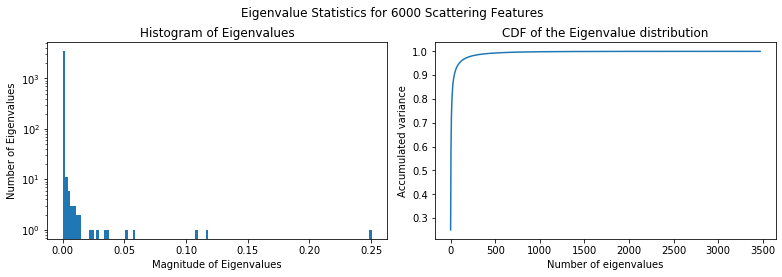

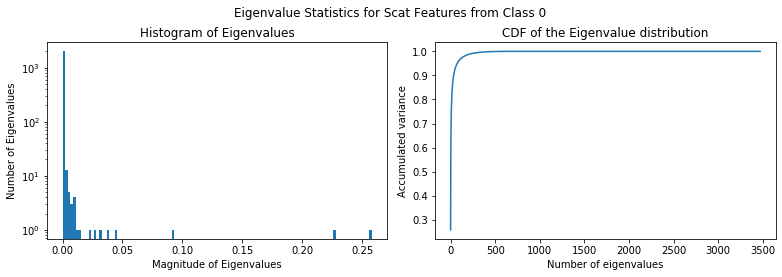

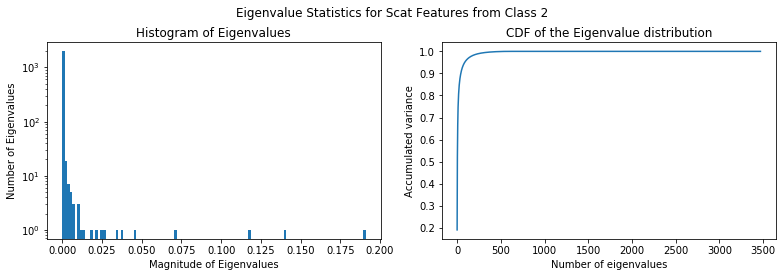

In [15]:
display_cluster_features(scat_eigenvalues_all, suptitle=f"Eigenvalue Statistics for {n_imgs} Scattering Features")
display_cluster_features(scat_evals_0, suptitle="Eigenvalue Statistics for Scat Features from Class 0 ")
display_cluster_features(scat_evals_2, suptitle="Eigenvalue Statistics for Scat Features from Class 2")

# Principal Angles

In this section, we compute the principal angles between the eigbasis of two MNIST classes. 
For illustrative purposes, we select the classes containing digits 0 and 2 respectively.

In [16]:
principal_angles_img = compute_principal_angles(P=img_evect_0,
                                                Q=img_evect_2,
                                                n_dims=n_angles)  

In [17]:
principal_angles_scat = compute_principal_angles(P=scat_evect_0,
                                                 Q=scat_evect_2,
                                                 n_dims=n_angles)

In [18]:
principal_angles_img = [round(a,3) for a in principal_angles_img]
principal_angles_scat = [round(a,3) for a in principal_angles_scat]

In [19]:
ang2deg = lambda x: np.round(np.array(x)*180/np.pi,1)

In [20]:
print("Image Principal Angles")
print("----------------------")
print(f"Angles in radians: {principal_angles_img}")
print(f"Angles in degrees: {ang2deg(principal_angles_img)}")

Image Principal Angles
----------------------
Angles in radians: [1.002, 1.108, 1.15, 1.164, 1.277, 1.289, 1.393, 1.442, 1.455, 1.472]
Angles in degrees: [57.4 63.5 65.9 66.7 73.2 73.9 79.8 82.6 83.4 84.3]


In [21]:
print("Scattering Principal Angles")
print("----------------------")
print(f"Angles in radians: {principal_angles_scat}")
print(f"Angles in degrees: {ang2deg(principal_angles_scat)}")

Scattering Principal Angles
----------------------
Angles in radians: [0.532, 0.725, 0.865, 1.044, 1.153, 1.181, 1.245, 1.335, 1.342, 1.471]
Angles in degrees: [30.5 41.5 49.6 59.8 66.1 67.7 71.3 76.5 76.9 84.3]
